In [ ]:
from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client.from_service_account_json('/Users/servandodavidtorresgarcia/servando/relu/gcp/local-catalyst-398309-52645c242657.json')


# Define your table and destination URI
dataset_name = 'thelook_ecommerce'
table_name = 'distribution_centers'
bucket_name = 'ecommerce_looker_download'
destination_uri = f"gs://{bucket_name}/{table_name}.csv"

# Create an extract job
dataset_ref = client.dataset(dataset_name, project='bigquery-public-data')
table_ref = dataset_ref.table(table_name)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    location='US',  # Location must match that of the source table.
)
extract_job.result()  # Wait for job to complete

print(f"Exported {dataset_name}.{table_name} to {destination_uri}")


In [1]:

from src.data.dataset_reader import DatasetReader
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
data_folder = Path("../data/raw").resolve()

products = DatasetReader(data_folder).get_data_csv('products.csv')
orders = DatasetReader(data_folder).get_data_csv('orders.csv')
order_items = DatasetReader(data_folder).get_data_csv('order_items.csv')
inventory_items = DatasetReader(data_folder).get_data_csv('inventory_items.csv')

In [2]:
# Select specific columns from each DataFrame
order_items_selected = order_items[['product_id','order_id','status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at', 'sale_price']]
orders_selected = orders[['order_id', 'gender', 'num_of_item']]  # Including 'order_id' for joining
products_selected = products[['id', 'cost', 'category', 'name', 'brand', 'retail_price', 'department', 'sku']]  # Including 'id' for joining

# Perform the join operations based on the relationships identified in the queries
# Assuming 'order_id' is common between 'order_items' and 'orders'
# Assuming 'product_id' is common between 'order_items' and 'products'

merged_df = order_items_selected \
    .merge(orders_selected, on='order_id', how='inner') \
    .merge(products_selected, left_on='product_id', right_on='id', how='inner')



In [3]:
merged_df.drop(columns=['product_id', 'order_id', 'id'], inplace=True)

In [4]:
# place sku to the beginning of the dataframe
cols = list(merged_df.columns)
cols.insert(0, cols.pop(cols.index('sku')))
merged_df = merged_df.loc[:, cols]


In [5]:

# checl if sale_price is equal to retail_price
merged_df.query('sale_price != retail_price')
merged_df.drop(columns=['retail_price'], inplace=True)

In [6]:
#trainsform dates to datetime
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])
merged_df['shipped_at'] = pd.to_datetime(merged_df['shipped_at'])
merged_df['delivered_at'] = pd.to_datetime(merged_df['delivered_at'])
merged_df['returned_at'] = pd.to_datetime(merged_df['returned_at'])

In [7]:
#merged_df.head()
#merged_df.groupby('sku').size().reset_index(name='sales')
# create column sales that is the number sales per sku
# Correct way to calculate sales per SKU
#merged_df['sales'] = merged_df.groupby('sku')['num_of_item'].transform('sum')


In [51]:
#merged_df.drop (columns=['sales'], inplace=True)
#print(merged_df.head().to_string())

                                sku    status                       created_at                       shipped_at                     delivered_at returned_at  sale_price gender  num_of_item     cost     category                                     name             brand department
0  4ACBEDBE977480D19B7B682D4878CAE2   Shipped        2023-08-20 21:21:15+00:00        2023-08-21 07:58:00+00:00                              NaT         NaT         2.5      F            4   1.1075  Accessories  Elegant PASHMINA SCARF WRAP SHAWL STOLE  Scarf_tradinginc      Women
1  4ACBEDBE977480D19B7B682D4878CAE2  Complete 2023-09-08 00:38:23.869168+00:00 2023-09-07 19:56:53.869168+00:00 2023-09-08 14:07:53.869168+00:00         NaT         2.5      F            4   1.1075  Accessories  Elegant PASHMINA SCARF WRAP SHAWL STOLE  Scarf_tradinginc      Women
2  E0F19F64F086E393CEB0CF4A8C561B51   Shipped        2023-08-24 21:44:30+00:00        2023-08-21 07:58:00+00:00                              NaT         NaT 

In [52]:
# Given the clarification, let's aggregate the data as discussed:

def aggregate_sales(data, sku_col='sku', price_col='sale_price', time_col='created_at', sales_col='num_of_item'):
    """Aggregate sales by SKU, price, and time."""
    # Extract the date from the timestamp for daily aggregation
    data['date'] = data[time_col].dt.date
    
    aggregated_data = data.groupby([sku_col, price_col, 'date'])[sales_col].sum().reset_index().rename(columns={sales_col: 'daily_sales'})
    
    return aggregated_data

# Using the sample dataset provided to aggregate sales
aggregated_sales_data = aggregate_sales(merged_df)

aggregated_sales_data.head()


,sku,sale_price,date,daily_sales
0,00003E3B9E5336685200AE85D21B4F5E,99.000000,2022-05-14,2
1,00003E3B9E5336685200AE85D21B4F5E,99.000000,2022-12-09,1
2,00003E3B9E5336685200AE85D21B4F5E,99.000000,2023-05-12,1
3,0004D0B59E19461FF126E3A08A814C33,79.949997,2020-08-31,1
4,0004D0B59E19461FF126E3A08A814C33,79.949997,2022-10-19,1


In [53]:
def aggregate_sales_with_all_columns(data, sku_col='sku', price_col='sale_price', time_col='created_at', sales_col='num_of_item'):
    """Aggregate sales by SKU, price, and time while retaining other columns."""
    
    # Extract the date from the timestamp for daily aggregation
    data['date'] = data[time_col].dt.date
    
    # Aggregating sales and retaining other columns
    aggregation_methods = {sales_col: 'sum'}
    for col in data.columns:
        if col not in [sku_col, price_col, 'date', sales_col]:
            aggregation_methods[col] = 'first'
    
    aggregated_data = data.groupby([sku_col, price_col, 'date']).agg(aggregation_methods).reset_index().rename(columns={sales_col: 'daily_sales'})
    
    return aggregated_data




In [55]:
merged_df = aggregate_sales_with_all_columns(merged_df)
merged_df.head()

,sku,sale_price,date,daily_sales,status,created_at,shipped_at,delivered_at,returned_at,gender,cost,category,name,brand,department
0,00003E3B9E5336685200AE85D21B4F5E,99.000000,2022-05-14,2,Shipped,2022-05-14 21:24:59+00:00,2022-05-15 20:22:00+00:00,NaT,NaT,F,56.232000,Pants & Capris,Anne Klein Women's Crop Pant,Anne Klein,Women
1,00003E3B9E5336685200AE85D21B4F5E,99.000000,2022-12-09,1,Complete,2022-12-09 03:58:35+00:00,2022-12-10 03:49:00+00:00,2022-12-10 13:54:00+00:00,NaT,F,56.232000,Pants & Capris,Anne Klein Women's Crop Pant,Anne Klein,Women
2,00003E3B9E5336685200AE85D21B4F5E,99.000000,2023-05-12,1,Complete,2023-05-12 23:08:53+00:00,2023-05-15 07:59:00+00:00,2023-05-18 01:27:00+00:00,NaT,F,56.232000,Pants & Capris,Anne Klein Women's Crop Pant,Anne Klein,Women
3,0004D0B59E19461FF126E3A08A814C33,79.949997,2020-08-31,1,Processing,2020-08-31 08:42:06+00:00,NaT,NaT,NaT,F,37.656449,Fashion Hoodies & Sweatshirts,The Bradford Exchange Breast Cancer Support Wo...,Bradford Exchange,Women
4,0004D0B59E19461FF126E3A08A814C33,79.949997,2022-10-19,1,Shipped,2022-10-19 10:38:15+00:00,2022-10-21 14:40:00+00:00,NaT,NaT,F,37.656449,Fashion Hoodies & Sweatshirts,The Bradford Exchange Breast Cancer Support Wo...,Bradford Exchange,Women


In [139]:
print(merged_df.head().to_string())

                                sku  sale_price        date  daily_sales      status                created_at                shipped_at              delivered_at returned_at gender       cost                       category                                                                              name              brand department
0  00003E3B9E5336685200AE85D21B4F5E   99.000000  2022-05-14            2     Shipped 2022-05-14 21:24:59+00:00 2022-05-15 20:22:00+00:00                       NaT         NaT      F  56.232000                 Pants & Capris                                                      Anne Klein Women's Crop Pant         Anne Klein      Women
1  00003E3B9E5336685200AE85D21B4F5E   99.000000  2022-12-09            1    Complete 2022-12-09 03:58:35+00:00 2022-12-10 03:49:00+00:00 2022-12-10 13:54:00+00:00         NaT      F  56.232000                 Pants & Capris                                                      Anne Klein Women's Crop Pant         Anne Klein    

In [56]:
# drop status = 'Cancelled'
merged_df = merged_df[merged_df['status'] != 'Cancelled']

In [57]:
from src.data.eda import Eda
eda = Eda()
eda.missing_values_table(merged_df)

The selected dataframe has 15 columns and 5 columns with missing values.


,Missing Values,% of Total Values
returned_at,134664,88.0
delivered_at,89906,58.8
shipped_at,35931,23.5
brand,120,0.1
name,11,0.0


In [47]:
#merged_df.to_csv('../data/processed/merged_df.csv', index=False)

In [58]:
# inspecting for seasonality
from src.data.seasonality import SeasonalityInspector, QuickSeasonalityInspector


# Initialize
inspector = SeasonalityInspector('created_at', 'daily_sales')
quick_inspector = QuickSeasonalityInspector()

# Load your data into a DataFrame called 'data'
# data = pd.read_csv('your_data.csv')

# Plot time series
#inspector.plot_time_series(merged_df, 'created_at', 'sales')



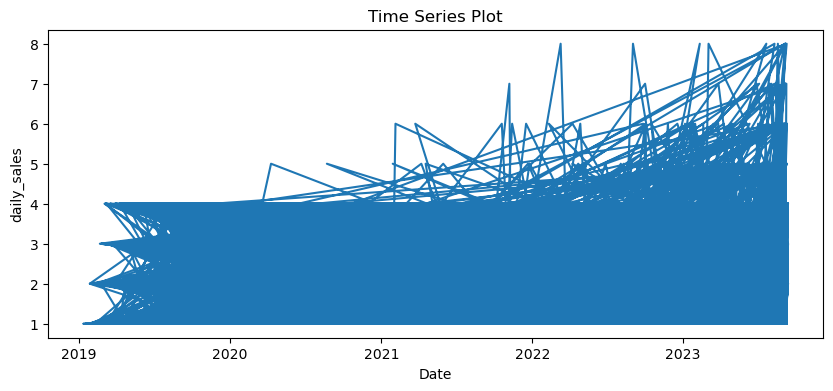

In [59]:
inspector.plot_time_series(merged_df)

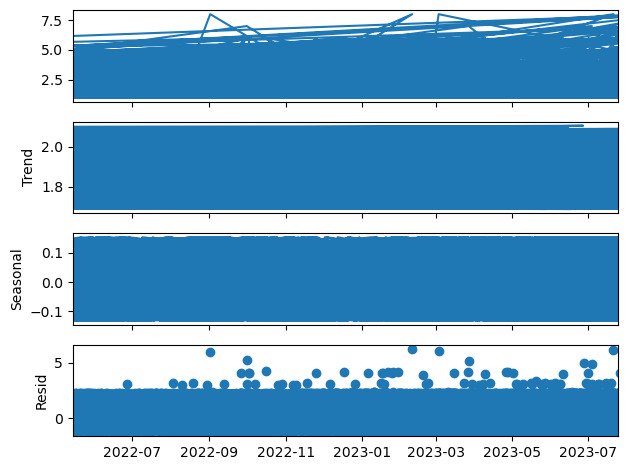

In [60]:
inspector.plot_decomposition(merged_df, 365)

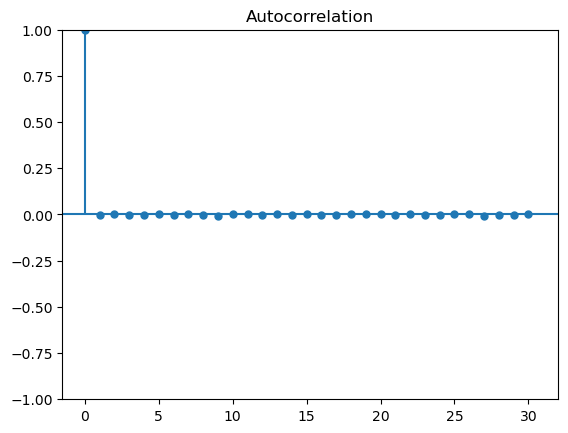

In [61]:
inspector.plot_autocorrelation(merged_df, 30)

In [62]:
from src.data.feature_engineering import FeatureEngineeringProcess
fep = FeatureEngineeringProcess()


In [63]:
merged_df_fe1 = fep.price_sales_correlation_features_updated(merged_df, 7, [(-5.0, 1.0), (-3.0, 1.0), (-2.0, 1.0), (1.0, 1.0), (-1.0, 0.5), (-1.0, 0.33)],
                                                             'sku', 'created_at', 'sale_price', 'daily_sales')

In [64]:
from src.data.eda import Eda
eda = Eda()

In [66]:
eda.missing_values_table(merged_df_fe1)

The selected dataframe has 21 columns and 11 columns with missing values.


,Missing Values,% of Total Values
f_corr_-5.0_1.0,135074,88.3
f_corr_-3.0_1.0,135074,88.3
f_corr_-2.0_1.0,135074,88.3
f_corr_1.0_1.0,135074,88.3
f_corr_-1.0_0.5,135074,88.3
f_corr_-1.0_0.33,135074,88.3
returned_at,134664,88.0
delivered_at,89906,58.8
shipped_at,35931,23.5
brand,120,0.1


In [67]:
# handle missing values in price_sales_correlation 
cols_to_fill_zero = [col for col in merged_df_fe1.columns if 'f_corr_' in col]
merged_df_fe1[cols_to_fill_zero] = merged_df_fe1[cols_to_fill_zero].fillna(0)


In [68]:
# Drop uneccesary date columns 
merged_df_fe1.drop(columns=['shipped_at', 'delivered_at', 'returned_at'], inplace=True)

In [69]:
eda.missing_values_table(merged_df_fe1)

The selected dataframe has 18 columns and 2 columns with missing values.


,Missing Values,% of Total Values
brand,120,0.1
name,11,0.0


In [71]:
merged_df_fe2 =  fep.normalize_features(merged_df_fe1, [5, 10, 15], 28, 'sku', 'created_at', 'sale_price', 'daily_sales')

In [72]:
eda.missing_values_table(merged_df_fe2)

The selected dataframe has 30 columns and 14 columns with missing values.


,Missing Values,% of Total Values
normalized_log_avg_price_5_days,152982,100.0
normalized_log_avg_sales_5_days,152982,100.0
normalized_log_avg_price_10_days,152982,100.0
normalized_log_avg_sales_10_days,152982,100.0
normalized_log_avg_price_15_days,152982,100.0
normalized_log_avg_sales_15_days,152982,100.0
normalized_std_price_15_days,152967,100.0
normalized_std_sales_15_days,152967,100.0
normalized_std_price_10_days,150646,98.5
normalized_std_sales_10_days,150646,98.5


In [73]:
# drop columns with 100% missing values
merged_df_fe2.dropna(axis=1, how='all', inplace=True)


In [74]:
eda.missing_values_table(merged_df_fe2)

The selected dataframe has 24 columns and 8 columns with missing values.


,Missing Values,% of Total Values
normalized_std_price_15_days,152967,100.0
normalized_std_sales_15_days,152967,100.0
normalized_std_price_10_days,150646,98.5
normalized_std_sales_10_days,150646,98.5
normalized_std_price_5_days,105307,68.8
normalized_std_sales_5_days,105307,68.8
brand,120,0.1
name,11,0.0


In [75]:
# drop normalized_std_price_15_days, normalized_std_sales_15_days, normalized_std_price_10_days, normalized_std_sales_10_days form merged_df_fe2
merged_df_fe2.drop(columns=['normalized_std_price_15_days', 'normalized_std_sales_15_days', 'normalized_std_price_10_days', 'normalized_std_sales_10_days'], inplace=True)


In [76]:
normalized_cols = [col for col in merged_df_fe2.columns if 'normalized_' in col]
merged_df_fe2[normalized_cols] = merged_df_fe2[normalized_cols].fillna(method='ffill').fillna(method='bfill')


In [77]:
eda.missing_values_table(merged_df_fe2)

The selected dataframe has 20 columns and 2 columns with missing values.


,Missing Values,% of Total Values
brand,120,0.1
name,11,0.0


In [91]:
merged_df_fe3, insuficient_data = fep.filter_stability_periods(merged_df_fe2, 7, 0.04, sku_column='sku', date_column='created_at', price_column='sale_price')

In [92]:
eda.missing_values_table(merged_df_fe3)

The selected dataframe has 20 columns and 2 columns with missing values.


,Missing Values,% of Total Values
brand,113,0.1
name,10,0.0


In [94]:
# drop missing values
merged_df_fe3.dropna(inplace=True)

In [95]:
eda.missing_values_table(merged_df_fe3)

The selected dataframe has 20 columns and 0 columns with missing values.


,Missing Values,% of Total Values


In [97]:
## embeddings
from src.data.embeddings import EmbeddingModel
import torch
from sklearn.preprocessing import LabelEncoder
#merged_df_embeddings = merged_df_fe3.copy()


label_encoders = {}
for col in ['category', 'name', 'brand', 'department']:
    le = LabelEncoder()
    merged_df_fe3[col] = le.fit_transform(merged_df_fe3[col])
    label_encoders[col] = le

embedding_dims = [(merged_df_fe3[col].max() + 1, int((merged_df_fe3[col].max() + 1) ** 0.5)) for col in ['category', 'name', 'brand', 'department']]
model = EmbeddingModel(embedding_dims)




#preapre data for embeddings
cat_data = merged_df_fe3[['category', 'name', 'brand', 'department']].values
cat_data_tensor = torch.tensor(cat_data, dtype=torch.long)


In [98]:
import torch.nn as nn
sales_data = merged_df_fe3['daily_sales'].values
sales_data_tensor = torch.tensor(sales_data, dtype=torch.float32).view(-1, 1)

import torch.optim as optim

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for a regression problem
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10  # Number of training epochs

for epoch in range(epochs):
    # Forward pass
    outputs = model(cat_data_tensor)
    
    # Compute loss
    loss = criterion(outputs, sales_data_tensor)

    # Zero gradients, backward pass, optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Inside Forward
Epoch [1/10], Loss: 5.7204
Inside Forward
Epoch [2/10], Loss: 5.6823
Inside Forward
Epoch [3/10], Loss: 5.6445
Inside Forward
Epoch [4/10], Loss: 5.6068
Inside Forward
Epoch [5/10], Loss: 5.5694
Inside Forward
Epoch [6/10], Loss: 5.5322
Inside Forward
Epoch [7/10], Loss: 5.4951
Inside Forward
Epoch [8/10], Loss: 5.4583
Inside Forward
Epoch [9/10], Loss: 5.4217
Inside Forward
Epoch [10/10], Loss: 5.3853


In [99]:

with torch.no_grad():
    embeddings = model.forward(cat_data_tensor).numpy()


Inside Forward


In [ ]:
eda.missing_values_table(merged_df_fe3)

In [100]:
# Reset Index Before Concatenating
merged_df_fe3.reset_index(drop=True, inplace=True)
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.reset_index(drop=True, inplace=True)
merged_df_embeddings = pd.concat([merged_df_fe3, embeddings_df], axis=1)


In [101]:
# check lenghts
assert len(merged_df_fe3) == len(embeddings_df), "Dataframes have different lengths."


In [102]:
eda.missing_values_table(merged_df_embeddings)

The selected dataframe has 242 columns and 0 columns with missing values.


,Missing Values,% of Total Values


In [ ]:
#merged_df_embeddings = pd.concat([merged_df_fe3, pd.DataFrame(embeddings)], axis=1)
#merged_df_embeddings.drop(['category', 'name', 'brand', 'department'], axis=1, inplace=True)


In [103]:
import numpy as np
# Create a correlation matrix to check for multicollinearity
corr_matrix = merged_df_embeddings.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Features to drop: {to_drop}")

Features to drop: ['cost', 'f_corr_-3.0_1.0', 'f_corr_-2.0_1.0', 'f_corr_1.0_1.0', 'f_corr_-1.0_0.5', 'f_corr_-1.0_0.33', 221]


In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Drop non-numeric columns for VIF calculation
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = merged_df_embeddings.select_dtypes(include=numerics)


# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = new_df.columns

vif_data["VIF"] = [variance_inflation_factor(new_df.values, i) for i in range(len(new_df.columns))]

# Identify features with a high VIF value
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"].tolist()

print(f"Features with high VIF should be removed or examined: {high_vif_features}")



Features with high VIF should be removed or examined: ['sale_price', 'cost', 'f_corr_-5.0_1.0', 'f_corr_-3.0_1.0', 'f_corr_-2.0_1.0', 'f_corr_1.0_1.0', 'f_corr_-1.0_0.5', 'f_corr_-1.0_0.33', 221]


In [105]:
print(to_drop)
print(high_vif_features)

['cost', 'f_corr_-3.0_1.0', 'f_corr_-2.0_1.0', 'f_corr_1.0_1.0', 'f_corr_-1.0_0.5', 'f_corr_-1.0_0.33', 221]
['sale_price', 'cost', 'f_corr_-5.0_1.0', 'f_corr_-3.0_1.0', 'f_corr_-2.0_1.0', 'f_corr_1.0_1.0', 'f_corr_-1.0_0.5', 'f_corr_-1.0_0.33', 221]


In [106]:
train_dataset = merged_df_embeddings.drop(columns=['f_corr_-3.0_1.0', 'f_corr_-2.0_1.0', 'f_corr_1.0_1.0', 'f_corr_-1.0_0.5', 'f_corr_-1.0_0.33', 221, 'cost', ], axis=1)

In [107]:
# drop categorical features used in embeddings

train_dataset = train_dataset.drop(columns=['category', 'name', 'brand', 'department'], axis=1)

In [108]:
train_dataset  =  fep.datetime_transform(train_dataset,'created_at', ['day_of_the_year'])


In [109]:
train_dataset.status.unique()
# drop skus with status "Returned" and "Cancelled"
train_dataset = train_dataset.query('status != "Returned" and status != "Cancelled"')


In [110]:
# use label encoder for status and gender


train_dataset['status'] = le.fit_transform(train_dataset['status'])
train_dataset['gender'] = le.fit_transform(train_dataset['gender'])



In [111]:
train_dataset.sort_values(by=['created_at'], inplace=True)

In [112]:
# print first and last date
print(train_dataset.created_at.min())
print(train_dataset.created_at.max())


2019-01-11 13:05:59+00:00
2023-09-11 18:25:47.230646+00:00


In [127]:
# print first and last date
print(train_dataset.date.min())
print(train_dataset.date.max())

2019-01-11
2023-09-11


In [113]:
from typing import Dict, Union
import pandas as pd

def describe_time_series(df: pd.DataFrame, date_column: str, sales_column: str) -> Dict[str, Union[int, Dict[int, Dict[str, int]]]]:
    """
    Function to provide a comprehensive description of the time series data.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the time series data.
    - date_column (str): Column name containing the date information.
    
    Returns:
    - Dict: Description containing number of years, months per year, and average sales per month.
    """

    # Convert date column to datetime if not already
    df[date_column] = pd.to_datetime(df[date_column])

    # Extract year and month from date
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month

    # Initialize results dictionary
    result = {
        "total_years": 0,
        "years_detail": {}
    }

    # Total number of unique years
    total_years = df['year'].nunique()
    result["total_years"] = total_years

    # Iterate over each year to find details
    for year in df['year'].unique():
        year_data = df[df['year'] == year]
        
        # Number of unique months in this year
        unique_months = year_data['month'].nunique()
        
        # Average sales per month
        avg_sales_per_month = year_data.groupby('month')[sales_column].mean().to_dict()

        # Add details to result
        result['years_detail'][year] = {
            "unique_months": unique_months,
            "avg_sales_per_month": avg_sales_per_month
        }

    return result

# Example usage (assuming 'merged_df' contains 'date' and 'sales' columns)
# describe_time_series(merged_df, 'date')






In [128]:
describe_time_series(train_dataset, 'date', 'daily_sales')

{'total_years': 5,
 'years_detail': {2019: {'unique_months': 12,
   'avg_sales_per_month': {1: 1.4,
    2: 1.48,
    3: 2.048780487804878,
    4: 2.1777777777777776,
    5: 1.7815533980582525,
    6: 1.8223350253807107,
    7: 1.990066225165563,
    8: 1.9176470588235295,
    9: 1.8306878306878307,
    10: 2.0351758793969847,
    11: 1.9553752535496958,
    12: 1.8697318007662835}},
  2020: {'unique_months': 12,
   'avg_sales_per_month': {1: 1.8076923076923077,
    2: 1.9568345323741008,
    3: 1.9124487004103967,
    4: 1.8771466314398944,
    5: 1.8451025056947608,
    6: 1.9126106194690264,
    7: 1.9145539906103286,
    8: 1.9170829170829171,
    9: 1.8141153081510935,
    10: 1.9156327543424319,
    11: 1.919871794871795,
    12: 1.9884704073789392}},
  2021: {'unique_months': 12,
   'avg_sales_per_month': {1: 1.8781416603198782,
    2: 1.9006823351023503,
    3: 1.8643954575818302,
    4: 1.820187165775401,
    5: 1.886687306501548,
    6: 1.9470387243735763,
    7: 1.94123711340

In [ ]:
# print min and max date
print(train_dataset.created_at.min())
print(train_dataset.created_at.max())

In [ ]:
# First localize to UTC and then convert to naive datetime
#train_dataset['created_at'] = pd.to_datetime(train_dataset['created_at'], utc=True).dt.tz_localize(None)

# Check unique dates and data types after conversion
#print("Unique dates after conversion:", train_dataset['created_at'].unique())
print("Data type after conversion:", train_dataset['created_at'].dtype)



In [130]:
train_dataset.drop(columns=['created_at'], inplace=True)

In [131]:

from src.data.data_splitter import DataSplitter


data_splitter = DataSplitter(train_dataset, 'daily_sales','sku', 'date', 36, 6, 4)
X_train, y_train, X_val, y_val, X_test, y_test = data_splitter.split_data()

Debug: Data type of date column before processing: datetime64[ns]
Debug: Unique dates before processing: ['2019-01-11T00:00:00.000000000' '2019-01-17T00:00:00.000000000'
 '2019-01-18T00:00:00.000000000' ... '2023-09-09T00:00:00.000000000'
 '2023-09-10T00:00:00.000000000' '2023-09-11T00:00:00.000000000']
Number of SKUs in train: 4387
Number of SKUs in validation: 28551
Number of SKUs in test: 6826
Min date in dataset: 2019-01-11 00:00:00
Max date in dataset: 2023-09-11 00:00:00
Train-Val threshold: 2020-03-11 00:00:00
Val-Test threshold: 2023-08-14 00:00:00
Training data covers from 2019-01-21 00:00:00 to 2020-03-11 00:00:00
Validation data covers from 2020-03-12 00:00:00 to 2023-08-14 00:00:00
Test data covers from 2023-08-15 00:00:00 to 2023-09-11 00:00:00


In [ ]:
print('X_val info', X_val.info())
print('X_train info', X_train.info())

In [132]:
X_train.head()

,sku,sale_price,status,gender,f_corr_-5.0_1.0,normalized_std_price_5_days,normalized_std_sales_5_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,created_at_day_of_the_year,year,month
44208,5421E013565F7F1AFA0CFE8AD87A99AB,46.990002,1,0,0.0,0.0,0.612372,0.921962,-0.202603,0.201644,0.027883,0.480924,-0.847797,-0.297774,-0.414589,1.681062,0.465758,0.910244,-2.149250,-2.270085,-1.701837,-0.247114,-0.819454,0.927107,1.013751,0.054008,-0.549068,-1.151687,-1.012792,-0.154113,2.233285,-0.110032,-0.313683,-1.470379,-0.990195,1.213581,0.945220,0.127053,0.886860,0.399266,-0.491119,0.258435,-0.249791,0.953746,0.941808,0.569349,0.253124,-1.124561,1.785446,0.054284,-0.223640,1.119226,1.520381,0.693328,0.129818,0.489036,1.933933,-1.452338,-0.220426,-0.772190,0.239840,0.383264,-0.639122,-0.521321,1.352267,1.250092,1.558873,-0.929664,0.436795,0.850540,-0.160297,1.002970,-0.391215,-0.092367,1.227552,0.937428,0.098412,0.078503,1.175277,0.917639,-0.321050,0.962657,-0.420428,0.792536,0.955240,0.847806,1.331405,-0.398860,0.457248,-1.297461,-1.673792,-0.858226,-1.014065,-0.041807,-0.439070,-0.160724,-0.584101,-0.998875,-1.136102,-1.438717,-1.639215,-0.446174,0.538729,1.444875,-0.720641,0.230464,0.771936,-1.115001,0.549142,-0.260043,0.113597,1.043823,-0.296960,0.547029,0.107469,1.396710,0.310142,-0.390403,0.268747,0.925746,0.315216,0.044480,0.134911,0.092306,0.383198,-0.007106,0.321449,-0.140343,-0.212127,0.132247,-0.239555,-0.898615,1.330596,-0.024629,-0.001123,0.851209,-0.598079,-0.918452,1.244818,-0.639142,-0.488102,-0.140695,1.584107,1.050629,0.407757,-1.333895,0.357115,-0.807828,-0.247712,0.153462,-0.167412,2.547471,1.080254,-0.716317,0.657381,0.771118,1.716084,-0.033039,-0.047118,-0.609030,-1.231619,1.213005,0.150806,-0.645272,0.697884,-1.651765,0.539463,1.363539,-1.067418,-0.751450,-1.340119,-0.330318,-0.273569,0.588018,-0.469029,1.422958,2.066719,0.925512,-1.187204,-0.154885,-0.720887,-0.616084,-0.087842,0.816454,-0.545247,0.506026,0.942514,-0.698180,-1.451078,-1.850516,-0.046616,-0.540395,-0.374718,0.736330,1.232586,1.623165,0.188401,0.550698,1.466799,0.168480,0.076813,-0.464321,0.714886,0.305455,-0.225403,-0.312075,-1.227738,-0.386652,1.740621,-0.411584,-0.911094,-1.185759,-0.932699,-1.546780,0.489515,0.715739,0.835501,0.780047,-0.831133,-1.087504,-0.067741,1.921461,0.333087,-0.517615,0.008957,-0.273704,-1.819881,0.176162,21,2019,1
16365,1EE42F91B329FEEBF2CD3DADD8A704F2,7.990000,2,0,0.0,0.0,0.724356,-0.067840,0.150709,2.328436,-0.290366,0.522021,0.880264,-0.440631,0.635810,-1.139494,0.811569,0.079848,-0.898761,-0.896586,0.046787,-0.322809,0.486583,-0.762113,0.471105,-0.052026,1.475905,-0.667470,0.111695,0.192273,-0.480790,0.579859,0.741601,-2.533859,1.858290,-0.207586,-2.660383,1.561860,0.370328,1.401307,0.880507,1.651745,-0.412075,0.126259,0.381490,0.679652,-0.008994,0.368217,1.068059,0.566060,1.828005,-0.453355,0.014733,1.162692,0.125434,-0.344077,-1.222933,0.301036,-0.373913,-1.456977,-0.404777,1.286745,0.396842,-1.122855,1.508495,0.121888,0.315083,-0.219856,1.961327,-0.277637,0.227770,-0.550152,0.748862,-0.378454,0.406217,0.494230,-1.752230,-0.039102,-0.788485,0.890652,-0.484236,0.009555,-0.046385,-0.357785,-1.819315,-0.762455,-0.060153,-0.748355,0.905856,0.065803,-0.217972,-0.317368,-0.989315,1.459561,2.123958,0.875842

In [133]:
# drop 'sku', 'year', 'month' from X_train and X_val
X_train.drop(columns=['sku', 'year', 'month'], inplace=True)
X_val.drop(columns=['sku', 'year', 'month'], inplace=True)

X_test.drop(columns=['year', 'month'], inplace=True)

In [119]:
# drop column "36" from X_train and X_val
#X_train.drop(columns=[36], inplace=True)
#X_val.drop(columns=[36], inplace=True)
#X_test.drop(columns=[36], inplace=True)


In [126]:
# show all dtypes from all columns

pd.set_option('display.max_rows', None)
print(X_train.dtypes)


sale_price                     float64
date                            object
status                           int64
gender                           int64
f_corr_-5.0_1.0                float64
normalized_std_price_5_days    float64
normalized_std_sales_5_days    float64
0                              float32
1                              float32
2                              float32
3                              float32
4                              float32
5                              float32
6                              float32
7                              float32
8                              float32
9                              float32
10                             float32
11                             float32
12                             float32
13                             float32
14                             float32
15                             float32
16                             float32
17                             float32
18                       

In [134]:
from src.train.quantile_training import DemandCurveTrainer
trainer = DemandCurveTrainer(X_train, y_train, X_val, y_val,  tune_params=True)
trainer.train_models()
trainer.evaluate_models()
#trainer.plot_feature_importance()
# Predict demand curve (Assume test_data is prepared with SKUs and prices)
sku_demand_curves, demand_curve_pricing, price_points_per_sku = trainer.predict_demand_curve(X_test, 'sku', 'sale_price')


[I 2023-09-13 19:45:04,278] A new study created in memory with name: no-name-c6a38b35-d30e-41e4-a585-bb26db503f9b


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2023-09-13 19:45:04,621] Trial 0 finished with value: 1.1228310151958358 and parameters: {'max_depth': 2, 'min_data_in_leaf': 16, 'subsample': 0.784477558438928, 'n_estimators': 54, 'learning_rate': 0.04014058691646706, 'colsample_bytree': 0.602353685083011}. Best is trial 0 with value: 1.1228310151958358.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2023-09-13 19:45:05,721] Trial 1 finished with value: 2.0590349666437224 and parameters: {'max_depth': 10, 'min_data_in_leaf': 12, 'subsample': 0.9525202999653877, 'n_estimators': 70, 'learning_rate': 0.12777834133040228, 'colsample_bytree': 0.969409046514714}. Best is trial 0 with value: 1.1228310151958358.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2023-09-13 19:45:06,508] Trial 2 finished with value: 2.086162592513635 and parameters: {'max_depth': 8, 'min_data_in_leaf': 14, 'subsample': 0.7466086675632426, 'n_estimators': 64, 'learning_rate': 0.16177333953735426, 'colsample_bytree': 0.9914715636951007}. Best is trial 0 with value: 1.1228310151958358.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2023-09-13 19:45:07,391] Trial 3 finished with value: 2.092488551681676 and parameters: {'max_depth': 10, 'min_data_in_leaf': 16, 'subsample': 0.71812979118186, 'n_estimators': 98, 'learning_rate': 0.1099540989865389, 'colsample_bytree': 0.6520209261525521}. Best is trial 0 with value: 1.1228310151958358.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2023-09-13 19:45:07,639] Trial 4 finished with value: 1.6790706348370557 and parameters: {'max_depth': 3, 'min_data_in_leaf': 10, 'subsample': 0.9093081414937982, 'n_estimators': 82, 'learning_rate': 0.1716724283998891, 'colsample_bytree': 0.8505452316950718}. Best is trial 0 with value: 1.1228310151958358.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2023-09-13 19:45:08,465] Trial 5 finished with value: 1.9707931137802093 and parameters: {'max_depth': 8, 'min_data_in_leaf': 16, 'subsample': 0.8795536441216674, 'n_estimators': 59, 'learning_rate': 0.13101016233201537, 'colsample_bytree': 0.9089652942761981}. Best is trial 0 with value: 1.1228310151958358.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2023-09-13 19:45:09,417] Trial 6 finished with value: 1.8664549592698534 and parameters: {'max_depth': 5, 'min_data_in_leaf': 7, 'subsample': 0.6129648684891668, 'n_estimators': 82, 'learning_rate': 0.09821960038054307, 'colsample_bytree': 0.9305860118502494}. Best is trial 0 with value: 1.1228310151958358.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:45:09,998] Trial 7 finished with value: 2.094539329414144 and parameters: {'max_depth': 9, 'min_data_in_leaf': 20, 'subsample': 0.6151156708966166, 'n_estimators': 73, 'learning_rate': 0.16680715123925755, 'colsample_bytree': 0.6279824136631964}. Best is trial 0 with value: 1.1228310151958358.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2023-09-13 19:45:11,098] Trial 8 finished with value: 2.0247933224836 and parameters: {'max_depth': 9, 'min_data_in_leaf': 10, 'subsample': 0.628731867040346, 'n_estimators': 91, 'learning_rate': 0.07868929169159125, 'colsample_bytree': 0.7271126620211835}. Best is trial 0 with value: 1.1228310151958358.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2023-09-13 19:45:11,750] Trial 9 finished with value: 1.7858209351512462 and parameters: {'max_depth': 9, 'min_data_in_leaf': 15, 'subsample': 0.7247533773029522, 'n_estimators': 51, 'learning_rate': 0.0839198313499117, 'colsample_bytree': 0.9508728324807512}. Best is trial 0 with value: 1.1228310151958358.
[I 2023-09-13 19:45:11,922] Trial 10 finished with value: 1.1081941568130373 and parameters: {'max_depth': 2, 'min_data_in_leaf': 20, 'subsample': 0.8380186464832848, 'n_estimators': 50, 'learning_rate': 0.01569907285202666, 'colsample_bytree': 0.7537200454555818}. Best is trial 10 with value: 1.1081941568130373.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:45:12,093] Trial 11 finished with value: 1.1085308286417945 and parameters: {'max_depth': 2, 'min_data_in_leaf': 20, 'subsample': 0.8301602715692501, 'n_estimators': 50, 'learning_rate': 0.016218743317496384, 'colsample_bytree': 0.7449012073347615}. Best is trial 10 with value: 1.1081941568130373.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:45:12,352] Trial 12 finished with value: 1.1185915969862836 and parameters: {'max_depth': 4, 'min_data_in_leaf': 20, 'subsample': 0.8470454478021574, 'n_estimators': 50, 'learning_rate': 0.01302340173356382, 'colsample_bytree': 0.7706372327330681}. Best is trial 10 with value: 1.1081941568130373.
[I 2023-09-13 19:45:12,517] Trial 13 finished with value: 1.107888370713473 and parameters: {'max_depth': 2, 'min_data_in_leaf': 18, 'subsample': 0.8325752118486046, 'n_estimators': 62, 'learning_rate': 0.012006775091858126, 'colsample_bytree': 0.7515416994474313}. Best is trial 13 with value: 1.107888370713473.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:45:12,987] Trial 14 finished with value: 1.3917348844694557 and parameters: {'max_depth': 6, 'min_data_in_leaf': 19, 'subsample': 0.9573241143911606, 'n_estimators': 63, 'learning_rate': 0.04782018772225821, 'colsample_bytree': 0.8152485792701092}. Best is trial 13 with value: 1.107888370713473.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-09-13 19:45:13,401] Trial 15 finished with value: 1.2276363761150182 and parameters: {'max_depth': 4, 'min_data_in_leaf': 18, 'subsample': 0.89196991728301, 'n_estimators': 59, 'learning_rate': 0.045799793724247875, 'colsample_bytree': 0.6870842070592342}. Best is trial 13 with value: 1.107888370713473.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-09-13 19:45:13,728] Trial 16 finished with value: 1.1166149363089537 and parameters: {'max_depth': 3, 'min_data_in_leaf': 18, 'subsample': 0.8112526315836798, 'n_estimators': 69, 'learning_rate': 0.013566941120458899, 'colsample_bytree': 0.6934468232639255}. Best is trial 13 with value: 1.107888370713473.
[I 2023-09-13 19:45:14,021] Trial 17 finished with value: 1.14778734786897 and parameters: {'max_depth': 2, 'min_data_in_leaf': 18, 'subsample': 0.996876572717378, 'n_estimators': 57, 'learning_rate': 0.06402331671420601, 'colsample_bytree': 0.7986602869143578}. Best is trial 13 with value: 1.107888370713473.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2023-09-13 19:45:14,627] Trial 18 finished with value: 1.3144395517136451 and parameters: {'max_depth': 5, 'min_data_in_leaf': 5, 'subsample': 0.7842482531919316, 'n_estimators': 65, 'learning_rate': 0.030020484691480234, 'colsample_bytree': 0.8458936317695537}. Best is trial 13 with value: 1.107888370713473.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2023-09-13 19:45:14,877] Trial 19 finished with value: 1.2556282452935073 and parameters: {'max_depth': 3, 'min_data_in_leaf': 13, 'subsample': 0.8526919348616645, 'n_estimators': 78, 'learning_rate': 0.058783132395954986, 'colsample_bytree': 0.7515487712974326}. Best is trial 13 with value: 1.107888370713473.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2023-09-13 19:45:15,291] Trial 20 finished with value: 1.2206371028211733 and parameters: {'max_depth': 6, 'min_data_in_leaf': 17, 'subsample': 0.8598476834985862, 'n_estimators': 56, 'learning_rate': 0.028736097685667053, 'colsample_bytree': 0.6862811620839595}. Best is trial 13 with value: 1.107888370713473.
[I 2023-09-13 19:45:15,436] Trial 21 finished with value: 1.1074726539740025 and parameters: {'max_depth': 2, 'min_data_in_leaf': 20, 'subsample': 0.8238809355339173, 'n_estimators': 50, 'learning_rate': 0.013255822427767818, 'colsample_bytree': 0.7339689848226759}. Best is trial 21 with value: 1.1074726539740025.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:45:15,619] Trial 22 finished with value: 1.1204259292453793 and parameters: {'max_depth': 2, 'min_data_in_leaf': 19, 'subsample': 0.8098386164428468, 'n_estimators': 61, 'learning_rate': 0.029417360194315276, 'colsample_bytree': 0.7156314951167275}. Best is trial 21 with value: 1.1074726539740025.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:45:15,894] Trial 23 finished with value: 1.115317922283867 and parameters: {'max_depth': 4, 'min_data_in_leaf': 20, 'subsample': 0.8358403478813888, 'n_estimators': 54, 'learning_rate': 0.010910481055679246, 'colsample_bytree': 0.7547651661673042}. Best is trial 21 with value: 1.1074726539740025.
[I 2023-09-13 19:45:16,135] Trial 24 finished with value: 1.1502515156811413 and parameters: {'max_depth': 3, 'min_data_in_leaf': 18, 'subsample': 0.8888103986272748, 'n_estimators': 67, 'learning_rate': 0.032784382231852024, 'colsample_bytree': 0.78587293412881}. Best is trial 21 with value: 1.1074726539740025.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-09-13 19:45:16,285] Trial 25 finished with value: 1.1319947597847657 and parameters: {'max_depth': 2, 'min_data_in_leaf': 17, 'subsample': 0.7776368846606044, 'n_estimators': 53, 'learning_rate': 0.05369564212285241, 'colsample_bytree': 0.7741254225045501}. Best is trial 21 with value: 1.1074726539740025.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2023-09-13 19:45:16,624] Trial 26 finished with value: 1.1346174998089946 and parameters: {'max_depth': 3, 'min_data_in_leaf': 19, 'subsample': 0.818358553971906, 'n_estimators': 58, 'learning_rate': 0.027764463198386366, 'colsample_bytree': 0.7297079725476666}. Best is trial 21 with value: 1.1074726539740025.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2023-09-13 19:45:16,997] Trial 27 finished with value: 1.4616135650225683 and parameters: {'max_depth': 5, 'min_data_in_leaf': 11, 'subsample': 0.8605693199793887, 'n_estimators': 61, 'learning_rate': 0.06441556470483784, 'colsample_bytree': 0.7085771513269787}. Best is trial 21 with value: 1.1074726539740025.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2023-09-13 19:45:17,244] Trial 28 finished with value: 1.2007510914648776 and parameters: {'max_depth': 4, 'min_data_in_leaf': 14, 'subsample': 0.9242748070467233, 'n_estimators': 54, 'learning_rate': 0.041196468010413885, 'colsample_bytree': 0.6696708602901325}. Best is trial 21 with value: 1.1074726539740025.
[I 2023-09-13 19:45:17,434] Trial 29 finished with value: 1.1443158107231515 and parameters: {'max_depth': 2, 'min_data_in_leaf': 15, 'subsample': 0.7891164873960939, 'n_estimators': 76, 'learning_rate': 0.04568956500934801, 'colsample_bytree': 0.648371272997317}. Best is trial 21 with value: 1.1074726539740025.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2023-09-13 19:45:17,857] Trial 30 finished with value: 1.1907598162637567 and parameters: {'max_depth': 7, 'min_data_in_leaf': 17, 'subsample': 0.7629178552997209, 'n_estimators': 54, 'learning_rate': 0.021194917590351157, 'colsample_bytree': 0.6184269193886489}. Best is trial 21 with value: 1.1074726539740025.
[I 2023-09-13 19:45:17,996] Trial 31 finished with value: 1.1061355867458609 and parameters: {'max_depth': 2, 'min_data_in_leaf': 20, 'subsample': 0.8351302807082532, 'n_estimators': 51, 'learning_rate': 0.010283539339441988, 'colsample_bytree': 0.7441088081337763}. Best is trial 31 with value: 1.1061355867458609.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:45:18,149] Trial 32 finished with value: 1.1113023817746814 and parameters: {'max_depth': 2, 'min_data_in_leaf': 19, 'subsample': 0.8270795940576208, 'n_estimators': 52, 'learning_rate': 0.021240591841278772, 'colsample_bytree': 0.7334253219854479}. Best is trial 31 with value: 1.1061355867458609.
[I 2023-09-13 19:45:18,365] Trial 33 finished with value: 1.1437946059924504 and parameters: {'max_depth': 3, 'min_data_in_leaf': 20, 'subsample': 0.8022972606312464, 'n_estimators': 56, 'learning_rate': 0.03399307135089902, 'colsample_bytree': 0.764115058045169}. Best is trial 31 with value: 1.1061355867458609.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:45:18,509] Trial 34 finished with value: 1.1070318690627337 and parameters: {'max_depth': 2, 'min_data_in_leaf': 19, 'subsample': 0.8539479304649595, 'n_estimators': 50, 'learning_rate': 0.012599749635391556, 'colsample_bytree': 0.7099749145452491}. Best is trial 31 with value: 1.1061355867458609.
[I 2023-09-13 19:45:18,707] Trial 35 finished with value: 1.1605434848677392 and parameters: {'max_depth': 3, 'min_data_in_leaf': 17, 'subsample': 0.8013690424683485, 'n_estimators': 62, 'learning_rate': 0.04015359126407937, 'colsample_bytree': 0.7127339052212154}. Best is trial 31 with value: 1.1061355867458609.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2023-09-13 19:45:18,880] Trial 36 finished with value: 1.1091616822079007 and parameters: {'max_depth': 2, 'min_data_in_leaf': 16, 'subsample': 0.8696770146588603, 'n_estimators': 66, 'learning_rate': 0.010543243788427928, 'colsample_bytree': 0.705802168103877}. Best is trial 31 with value: 1.1061355867458609.
[I 2023-09-13 19:45:19,096] Trial 37 finished with value: 1.1415500975431592 and parameters: {'max_depth': 3, 'min_data_in_leaf': 19, 'subsample': 0.8758268901276577, 'n_estimators': 71, 'learning_rate': 0.025441774225144976, 'colsample_bytree': 0.6686402082083721}. Best is trial 31 with value: 1.1061355867458609.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-09-13 19:45:19,454] Trial 38 finished with value: 1.2608770439058268 and parameters: {'max_depth': 4, 'min_data_in_leaf': 18, 'subsample': 0.9055463165355926, 'n_estimators': 89, 'learning_rate': 0.0369500727986643, 'colsample_bytree': 0.7354791837508879}. Best is trial 31 with value: 1.1061355867458609.
[I 2023-09-13 19:45:19,608] Trial 39 finished with value: 1.1141499949597555 and parameters: {'max_depth': 2, 'min_data_in_leaf': 16, 'subsample': 0.7643317915391312, 'n_estimators': 55, 'learning_rate': 0.022603504872440908, 'colsample_bytree': 0.8137155461208976}. Best is trial 31 with value: 1.1061355867458609.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2023-09-13 19:45:19,915] Trial 40 finished with value: 1.1104298860942332 and parameters: {'max_depth': 3, 'min_data_in_leaf': 8, 'subsample': 0.8392845726487248, 'n_estimators': 52, 'learning_rate': 0.010506955396040081, 'colsample_bytree': 0.7245155633022382}. Best is trial 31 with value: 1.1061355867458609.
[I 2023-09-13 19:45:20,049] Trial 41 finished with value: 1.1111631944689095 and parameters: {'max_depth': 2, 'min_data_in_leaf': 20, 'subsample': 0.8336360957376013, 'n_estimators': 50, 'learning_rate': 0.02123890877715491, 'colsample_bytree': 0.7555369371733475}. Best is trial 31 with value: 1.1061355867458609.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:45:20,217] Trial 42 finished with value: 1.1125951951668716 and parameters: {'max_depth': 2, 'min_data_in_leaf': 19, 'subsample': 0.8538087363908993, 'n_estimators': 59, 'learning_rate': 0.02000252046594112, 'colsample_bytree': 0.7881625884350343}. Best is trial 31 with value: 1.1061355867458609.
[I 2023-09-13 19:45:20,373] Trial 43 finished with value: 1.118520584091382 and parameters: {'max_depth': 2, 'min_data_in_leaf': 20, 'subsample': 0.8204951371218817, 'n_estimators': 51, 'learning_rate': 0.03668604894797713, 'colsample_bytree': 0.7408552572763099}. Best is trial 31 with value: 1.1061355867458609.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:45:20,572] Trial 44 finished with value: 1.1182864303699478 and parameters: {'max_depth': 3, 'min_data_in_leaf': 19, 'subsample': 0.8651248749104503, 'n_estimators': 50, 'learning_rate': 0.017968072292240983, 'colsample_bytree': 0.7757364112361989}. Best is trial 31 with value: 1.1061355867458609.
[I 2023-09-13 19:45:20,717] Trial 45 finished with value: 1.1074990869773536 and parameters: {'max_depth': 2, 'min_data_in_leaf': 20, 'subsample': 0.7957903510162856, 'n_estimators': 57, 'learning_rate': 0.011064740953182677, 'colsample_bytree': 0.7423647377469246}. Best is trial 31 with value: 1.1061355867458609.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-09-13 19:45:21,222] Trial 46 finished with value: 1.1383971046733412 and parameters: {'max_depth': 7, 'min_data_in_leaf': 18, 'subsample': 0.7927513130905204, 'n_estimators': 58, 'learning_rate': 0.01067610648086575, 'colsample_bytree': 0.7172336030755374}. Best is trial 31 with value: 1.1061355867458609.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2023-09-13 19:45:22,223] Trial 47 finished with value: 1.8728903394985927 and parameters: {'max_depth': 10, 'min_data_in_leaf': 15, 'subsample': 0.8174846140863101, 'n_estimators': 99, 'learning_rate': 0.051274655276070294, 'colsample_bytree': 0.696395866833583}. Best is trial 31 with value: 1.1061355867458609.
[I 2023-09-13 19:45:22,433] Trial 48 finished with value: 1.15560348714574 and parameters: {'max_depth': 3, 'min_data_in_leaf': 20, 'subsample': 0.7421573647940515, 'n_estimators': 60, 'learning_rate': 0.038558343468255464, 'colsample_bytree': 0.7436141538924597}. Best is trial 31 with value: 1.1061355867458609.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:45:22,697] Trial 49 finished with value: 1.1461981961208276 and parameters: {'max_depth': 4, 'min_data_in_leaf': 19, 'subsample': 0.8496661303475169, 'n_estimators': 56, 'learning_rate': 0.02369947337704229, 'colsample_bytree': 0.6794245791086566}. Best is trial 31 with value: 1.1061355867458609.


Fitting model for quantile 0.1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[1]	valid_0's quantile: 0.0917538
[2]	valid_0's quantile: 0.0971707
[3]	valid_0's quantile: 0.0994587
[4]	valid_0's quantile: 0.101518
[5]	valid_0's quantile: 0.103738
[6]	valid_0's quantile: 0.105286
[7]	valid_0's quantile: 0.106598
[8]	valid_0's quantile: 0.108312
[9]	valid_0's quantile: 0.111004
[10]	valid_0's quantile: 0.112238
[11]	valid_0's quantile: 0.115017
[12]	valid_0's quantile: 0.117504
[13]	valid_0's quantile: 0.118044
[14]	valid_0's quantile: 0.118334
[15]	valid_0's quantile: 0.118851
[16]	valid_0's quantile: 0.11882
[17]	valid_0's quantile: 0.118823
[18]	valid_0's quantile: 0.118797
[19]	valid_0's quantile: 0.118743
[20]	valid_0's quantile: 0.118697
[21]	valid_0's quantile: 0.118685
Fitting model for quantile 0.5
[1]	valid_0's quantile: 0.425504
[2]	valid_0's quantile: 0.427596
[3]	valid_0's quantile: 0.429582
[4]	valid_

In [135]:
import plotly.express as px
import pandas as pd


def plot_demand_curve_for_sku(sku_demand_curves, price_points_per_sku, selected_sku):
    # Create the DataFrame properly
    data = []
    for sku, sku_demand_curve in sku_demand_curves.items():
        if sku == selected_sku:  # Only proceed if the SKU matches
            for q, demand_predictions in sku_demand_curve.items():
                for price, prediction in zip(price_points_per_sku[sku], demand_predictions):
                    data.append({'SKU': sku, 'Price Points': price, 'Predicted Sales': prediction, 'Quantile': f'Quantile {q}'})
    
    df = pd.DataFrame(data)
    
    # Create the Plotly figure for the selected SKU
    fig = px.line(df, x='Price Points', y='Predicted Sales', color='Quantile',
                  title=f'Demand Curve for SKU: {selected_sku}',
                  labels={'Price Points': 'Price Points', 'Predicted Sales': 'Predicted Sales'})
    fig.show()

In [136]:
plot_demand_curve_for_sku(sku_demand_curves, price_points_per_sku, selected_sku="0129A222FE10C9896DB191C537694699")

[I 2023-09-13 19:45:55,713] A new study created in memory with name: no-name-06b9d2fa-4f7a-4bb3-9884-dc081a527c9e


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2023-09-13 19:45:56,075] Trial 0 finished with value: 1.475300871577107 and parameters: {'max_depth': 4, 'min_data_in_leaf': 11, 'subsample': 0.914862833911796, 'n_estimators': 90, 'learning_rate': 0.06633438197259535, 'colsample_bytree': 0.7014996981315179}. Best is trial 0 with value: 1.475300871577107.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2023-09-13 19:45:56,303] Trial 1 finished with value: 1.6624264662712047 and parameters: {'max_depth': 3, 'min_data_in_leaf': 8, 'subsample': 0.733786453611167, 'n_estimators': 79, 'learning_rate': 0.1747974816813076, 'colsample_bytree': 0.7395072936181479}. Best is trial 0 with value: 1.475300871577107.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2023-09-13 19:45:57,102] Trial 2 finished with value: 2.0998143799319804 and parameters: {'max_depth': 7, 'min_data_in_leaf': 8, 'subsample': 0.8676420418250663, 'n_estimators': 70, 'learning_rate': 0.1357559773628564, 'colsample_bytree': 0.6036807864167467}. Best is trial 0 with value: 1.475300871577107.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2023-09-13 19:45:57,558] Trial 3 finished with value: 1.1742974640923123 and parameters: {'max_depth': 6, 'min_data_in_leaf': 13, 'subsample': 0.7731303748726855, 'n_estimators': 57, 'learning_rate': 0.01764937022640961, 'colsample_bytree': 0.657507223238209}. Best is trial 3 with value: 1.1742974640923123.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2023-09-13 19:45:58,019] Trial 4 finished with value: 1.805819774622091 and parameters: {'max_depth': 5, 'min_data_in_leaf': 11, 'subsample': 0.6212284593244791, 'n_estimators': 63, 'learning_rate': 0.12467497990312801, 'colsample_bytree': 0.8298688350620707}. Best is trial 3 with value: 1.1742974640923123.
[I 2023-09-13 19:45:58,164] Trial 5 finished with value: 1.2263135178367064 and parameters: {'max_depth': 2, 'min_data_in_leaf': 16, 'subsample': 0.9211314246582029, 'n_estimators': 69, 'learning_rate': 0.11777071901807659, 'colsample_bytree': 0.8732083362883518}. Best is trial 3 with value: 1.1742974640923123.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:45:59,321] Trial 6 finished with value: 1.49041988060256 and parameters: {'max_depth': 9, 'min_data_in_leaf': 19, 'subsample': 0.8669340871755367, 'n_estimators': 92, 'learning_rate': 0.029731227875174786, 'colsample_bytree': 0.9429753023814309}. Best is trial 3 with value: 1.1742974640923123.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2023-09-13 19:46:00,086] Trial 7 finished with value: 1.5987395144645962 and parameters: {'max_depth': 7, 'min_data_in_leaf': 15, 'subsample': 0.9083694064433376, 'n_estimators': 78, 'learning_rate': 0.04975149670265009, 'colsample_bytree': 0.663740850639934}. Best is trial 3 with value: 1.1742974640923123.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2023-09-13 19:46:01,127] Trial 8 finished with value: 2.0903636349306796 and parameters: {'max_depth': 8, 'min_data_in_leaf': 6, 'subsample': 0.8274231981805448, 'n_estimators': 76, 'learning_rate': 0.12927835712471644, 'colsample_bytree': 0.7909570778791533}. Best is trial 3 with value: 1.1742974640923123.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2023-09-13 19:46:01,535] Trial 9 finished with value: 1.432644480750065 and parameters: {'max_depth': 7, 'min_data_in_leaf': 15, 'subsample': 0.7428294752916573, 'n_estimators': 50, 'learning_rate': 0.053313215954717004, 'colsample_bytree': 0.6026366926375734}. Best is trial 3 with value: 1.1742974640923123.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:02,325] Trial 10 finished with value: 1.1416646102561923 and parameters: {'max_depth': 10, 'min_data_in_leaf': 20, 'subsample': 0.978675916994799, 'n_estimators': 50, 'learning_rate': 0.010491377150892628, 'colsample_bytree': 0.9988663486918246}. Best is trial 10 with value: 1.1416646102561923.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:03,033] Trial 11 finished with value: 1.140165940993059 and parameters: {'max_depth': 10, 'min_data_in_leaf': 20, 'subsample': 0.9799079664098158, 'n_estimators': 50, 'learning_rate': 0.010155705799039539, 'colsample_bytree': 0.9976889824568975}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:03,743] Trial 12 finished with value: 1.186245109030033 and parameters: {'max_depth': 10, 'min_data_in_leaf': 20, 'subsample': 0.9691372461432014, 'n_estimators': 50, 'learning_rate': 0.017276399404634657, 'colsample_bytree': 0.9882333119903393}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-09-13 19:46:04,441] Trial 13 finished with value: 1.7718537224375792 and parameters: {'max_depth': 10, 'min_data_in_leaf': 18, 'subsample': 0.9960799067244336, 'n_estimators': 58, 'learning_rate': 0.07821656367995782, 'colsample_bytree': 0.995584484472701}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2023-09-13 19:46:05,155] Trial 14 finished with value: 1.1557113580770697 and parameters: {'max_depth': 9, 'min_data_in_leaf': 17, 'subsample': 0.9999432807049045, 'n_estimators': 57, 'learning_rate': 0.010697140739682046, 'colsample_bytree': 0.914185453615808}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:06,202] Trial 15 finished with value: 1.8545914002121515 and parameters: {'max_depth': 10, 'min_data_in_leaf': 20, 'subsample': 0.9514673344887081, 'n_estimators': 63, 'learning_rate': 0.09164802807864607, 'colsample_bytree': 0.9501518527637423}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-09-13 19:46:07,150] Trial 16 finished with value: 1.4036815604642439 and parameters: {'max_depth': 9, 'min_data_in_leaf': 18, 'subsample': 0.9579669883617018, 'n_estimators': 50, 'learning_rate': 0.043539770893737666, 'colsample_bytree': 0.8893798183268684}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2023-09-13 19:46:08,191] Trial 17 finished with value: 1.6134904557704823 and parameters: {'max_depth': 8, 'min_data_in_leaf': 13, 'subsample': 0.9980295715612705, 'n_estimators': 85, 'learning_rate': 0.03766230201355499, 'colsample_bytree': 0.9662832354646941}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:08,976] Trial 18 finished with value: 1.1496319667596617 and parameters: {'max_depth': 8, 'min_data_in_leaf': 20, 'subsample': 0.9404150759897312, 'n_estimators': 63, 'learning_rate': 0.010397559143294011, 'colsample_bytree': 0.9241262816395491}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2023-09-13 19:46:09,668] Trial 19 finished with value: 1.6187908637121076 and parameters: {'max_depth': 5, 'min_data_in_leaf': 17, 'subsample': 0.8954986173554498, 'n_estimators': 98, 'learning_rate': 0.06172960912614288, 'colsample_bytree': 0.9663521908900767}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2023-09-13 19:46:10,582] Trial 20 finished with value: 1.4204855224624227 and parameters: {'max_depth': 10, 'min_data_in_leaf': 15, 'subsample': 0.9551626926777529, 'n_estimators': 55, 'learning_rate': 0.03611194272220597, 'colsample_bytree': 0.8746173606200515}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:11,372] Trial 21 finished with value: 1.151951110807391 and parameters: {'max_depth': 8, 'min_data_in_leaf': 20, 'subsample': 0.9321569337261433, 'n_estimators': 65, 'learning_rate': 0.010316008855268356, 'colsample_bytree': 0.9986753438016656}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-09-13 19:46:12,040] Trial 22 finished with value: 1.3463415945581507 and parameters: {'max_depth': 9, 'min_data_in_leaf': 18, 'subsample': 0.9665365070110777, 'n_estimators': 54, 'learning_rate': 0.03531669412433834, 'colsample_bytree': 0.9434705082440169}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:46:12,848] Trial 23 finished with value: 1.2701738679386931 and parameters: {'max_depth': 8, 'min_data_in_leaf': 19, 'subsample': 0.8822432927808869, 'n_estimators': 61, 'learning_rate': 0.025857766782203216, 'colsample_bytree': 0.9202904990368399}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:13,925] Trial 24 finished with value: 1.1619843999784927 and parameters: {'max_depth': 9, 'min_data_in_leaf': 20, 'subsample': 0.9368177532405483, 'n_estimators': 69, 'learning_rate': 0.010219031186327696, 'colsample_bytree': 0.9960247339278542}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2023-09-13 19:46:14,720] Trial 25 finished with value: 1.2993362382163887 and parameters: {'max_depth': 10, 'min_data_in_leaf': 17, 'subsample': 0.9792045689643727, 'n_estimators': 53, 'learning_rate': 0.027549430124827516, 'colsample_bytree': 0.9227621551734517}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:46:15,323] Trial 26 finished with value: 1.387209422393076 and parameters: {'max_depth': 6, 'min_data_in_leaf': 19, 'subsample': 0.9413525592140044, 'n_estimators': 60, 'learning_rate': 0.04993572036812695, 'colsample_bytree': 0.9685138855968185}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2023-09-13 19:46:16,183] Trial 27 finished with value: 1.3260845280553908 and parameters: {'max_depth': 9, 'min_data_in_leaf': 16, 'subsample': 0.9744241958114023, 'n_estimators': 66, 'learning_rate': 0.02512664210700887, 'colsample_bytree': 0.9020224283901228}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:46:16,756] Trial 28 finished with value: 1.5851911285162492 and parameters: {'max_depth': 8, 'min_data_in_leaf': 19, 'subsample': 0.9002747658552066, 'n_estimators': 53, 'learning_rate': 0.07121962425586989, 'colsample_bytree': 0.9454695871662694}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2023-09-13 19:46:17,788] Trial 29 finished with value: 1.8688517666940594 and parameters: {'max_depth': 10, 'min_data_in_leaf': 11, 'subsample': 0.919937062023512, 'n_estimators': 72, 'learning_rate': 0.06464082583579592, 'colsample_bytree': 0.8507482930182411}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2023-09-13 19:46:18,777] Trial 30 finished with value: 1.537889889301957 and parameters: {'max_depth': 7, 'min_data_in_leaf': 9, 'subsample': 0.9306358536990395, 'n_estimators': 59, 'learning_rate': 0.04316360669803583, 'colsample_bytree': 0.9688368295731835}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:19,522] Trial 31 finished with value: 1.1595853923236956 and parameters: {'max_depth': 8, 'min_data_in_leaf': 20, 'subsample': 0.9388646162049963, 'n_estimators': 66, 'learning_rate': 0.011163939542463289, 'colsample_bytree': 0.998364864293343}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:20,181] Trial 32 finished with value: 1.2396523009768237 and parameters: {'max_depth': 6, 'min_data_in_leaf': 20, 'subsample': 0.9780878520909256, 'n_estimators': 81, 'learning_rate': 0.023091113385787537, 'colsample_bytree': 0.99854341893927}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-09-13 19:46:20,986] Trial 33 finished with value: 1.294724840061002 and parameters: {'max_depth': 9, 'min_data_in_leaf': 18, 'subsample': 0.8630222217669714, 'n_estimators': 64, 'learning_rate': 0.0241976710261904, 'colsample_bytree': 0.968545632106892}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:46:21,709] Trial 34 finished with value: 1.1591014379713944 and parameters: {'max_depth': 7, 'min_data_in_leaf': 19, 'subsample': 0.9274119392514054, 'n_estimators': 73, 'learning_rate': 0.011268913300372774, 'colsample_bytree': 0.9226586168648836}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:22,008] Trial 35 finished with value: 1.1707459361669086 and parameters: {'max_depth': 4, 'min_data_in_leaf': 20, 'subsample': 0.9003390353162113, 'n_estimators': 55, 'learning_rate': 0.03316701804108029, 'colsample_bytree': 0.9376368793825932}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2023-09-13 19:46:22,955] Trial 36 finished with value: 1.2818455016269301 and parameters: {'max_depth': 8, 'min_data_in_leaf': 14, 'subsample': 0.8348822830799294, 'n_estimators': 67, 'learning_rate': 0.021319336842320433, 'colsample_bytree': 0.980734721926931}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2023-09-13 19:46:23,703] Trial 37 finished with value: 1.5182050977865305 and parameters: {'max_depth': 5, 'min_data_in_leaf': 5, 'subsample': 0.9539135011946153, 'n_estimators': 62, 'learning_rate': 0.05709826891940988, 'colsample_bytree': 0.9549788777002614}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2023-09-13 19:46:24,497] Trial 38 finished with value: 1.4572132005305407 and parameters: {'max_depth': 10, 'min_data_in_leaf': 16, 'subsample': 0.9187980021155512, 'n_estimators': 57, 'learning_rate': 0.03891529514318468, 'colsample_bytree': 0.8933599016486355}. Best is trial 11 with value: 1.140165940993059.
[I 2023-09-13 19:46:24,721] Trial 39 finished with value: 1.3761324634820804 and parameters: {'max_depth': 3, 'min_data_in_leaf': 18, 'subsample': 0.9842154230870506, 'n_estimators': 52, 'learning_rate': 0.15064937471172898, 'colsample_bytree': 0.976471439503523}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:46:25,695] Trial 40 finished with value: 1.2748785399831288 and parameters: {'max_depth': 9, 'min_data_in_leaf': 19, 'subsample': 0.8821402197091183, 'n_estimators': 82, 'learning_rate': 0.01775831031349924, 'colsample_bytree': 0.934880098256986}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2023-09-13 19:46:26,520] Trial 41 finished with value: 1.1716158052893815 and parameters: {'max_depth': 9, 'min_data_in_leaf': 17, 'subsample': 0.9999239935987696, 'n_estimators': 57, 'learning_rate': 0.013293626281759233, 'colsample_bytree': 0.9108387311029281}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2023-09-13 19:46:27,301] Trial 42 finished with value: 1.2234052489291476 and parameters: {'max_depth': 10, 'min_data_in_leaf': 17, 'subsample': 0.964879823628989, 'n_estimators': 55, 'learning_rate': 0.019168308833468456, 'colsample_bytree': 0.9265063426126549}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:27,947] Trial 43 finished with value: 1.275811069889851 and parameters: {'max_depth': 8, 'min_data_in_leaf': 20, 'subsample': 0.9844135748584728, 'n_estimators': 51, 'learning_rate': 0.03062041718655184, 'colsample_bytree': 0.9817246021474973}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:46:28,673] Trial 44 finished with value: 1.147723163992194 and parameters: {'max_depth': 9, 'min_data_in_leaf': 19, 'subsample': 0.9997543727274107, 'n_estimators': 57, 'learning_rate': 0.010570595426567431, 'colsample_bytree': 0.9525793522778705}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:46:29,911] Trial 45 finished with value: 1.5371682625755587 and parameters: {'max_depth': 10, 'min_data_in_leaf': 19, 'subsample': 0.9461502316054009, 'n_estimators': 65, 'learning_rate': 0.04470292058884518, 'colsample_bytree': 0.9533357037512934}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-09-13 19:46:30,605] Trial 46 finished with value: 1.1830496199053857 and parameters: {'max_depth': 7, 'min_data_in_leaf': 20, 'subsample': 0.9658395180512553, 'n_estimators': 59, 'learning_rate': 0.01790910988657042, 'colsample_bytree': 0.9996526690814624}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-09-13 19:46:31,527] Trial 47 finished with value: 1.3410447364016949 and parameters: {'max_depth': 9, 'min_data_in_leaf': 18, 'subsample': 0.9139661485885024, 'n_estimators': 61, 'learning_rate': 0.02987134629444054, 'colsample_bytree': 0.9800793143609413}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2023-09-13 19:46:33,872] Trial 48 finished with value: 1.6038188109481675 and parameters: {'max_depth': 10, 'min_data_in_leaf': 9, 'subsample': 0.986504795119258, 'n_estimators': 50, 'learning_rate': 0.04872574947041404, 'colsample_bytree': 0.9526346539940451}. Best is trial 11 with value: 1.140165940993059.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2023-09-13 19:46:34,827] Trial 49 finished with value: 1.1975558794986096 and parameters: {'max_depth': 8, 'min_data_in_leaf': 19, 'subsample': 0.9491652629401307, 'n_estimators': 57, 'learning_rate': 0.01921525884835504, 'colsample_bytree': 0.7926211878387852}. Best is trial 11 with value: 1.140165940993059.


KeyError: 0.1

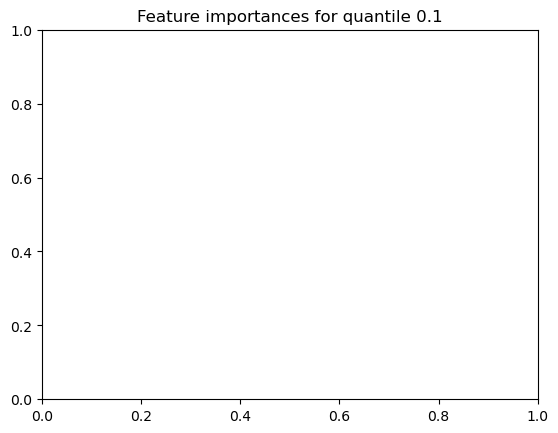

In [137]:
from src.train.quantile_training import DemandCurveTrainer
trainer = DemandCurveTrainer(X_train, y_train, X_val, y_val,  tune_params=True)
trainer.plot_feature_importance()